In [49]:
!date

Mon Oct 28 00:20:44 PDT 2024


In [50]:
%env CONDA_PREFIX

'/c4/home/derek/miniconda3/envs/deepripe'

# Model Evalutation with GIA and weight vis

In [51]:
import numpy as np
np.random.seed(1)

import os
import random
import sys
import glob
import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [251]:
import pandas as pd
import scipy as sci
import seaborn as sns
import matplotlib.pyplot as plt


from pathlib import Path
import json
import shutil


import pysam 
from scipy.stats import pearsonr, spearmanr


#import modified basenji modules 
sys.path.append("/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing")
from basenji_.basenji.dna_io import dna_1hot

import tensorflow as tf
from keras import regularizers

from scipy.ndimage import gaussian_filter1d

In [252]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [253]:
##set memory usage 

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

RuntimeError: Physical devices cannot be modified after being initialized

## generate and train ExplaiNN model 

In [288]:
model_path = '/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing/DeepRiPe/'

In [289]:
sys.path.append(model_path+'Scripts/')

from util_funcs import precision, recall

custom_objects={'precision':precision,
                'recall':recall,
                  }

In [290]:
seq_len = 600
region_len = 1000
input_sequence_split = 4
n_tasks = 2

In [291]:
input_seq = tf.keras.Input(shape=(seq_len, 4), name='input_seq')
input_region = tf.keras.Input(shape=(region_len, 4), name='input_region')
                           
input_seq_1, input_seq_2, input_seq_3, input_seq_4 = tf.split(input_seq, input_sequence_split, axis=1)
input_region_1, input_region_2, input_region_3, input_region_4 = tf.split(input_region, input_sequence_split, axis=1)
                              
inputs_seq = {}
inputs_region = {}

inputs_seq[0] = tf.keras.layers.Masking(mask_value=0)(input_seq_1)
inputs_seq[1] = tf.keras.layers.Masking(mask_value=0)(input_seq_2)
inputs_seq[2] = tf.keras.layers.Masking(mask_value=0)(input_seq_3)
inputs_seq[3] = tf.keras.layers.Masking(mask_value=0)(input_seq_4)

inputs_region[0] = tf.keras.layers.Masking(mask_value=0)(input_region_1)
inputs_region[1] = tf.keras.layers.Masking(mask_value=0)(input_region_2)
inputs_region[2] = tf.keras.layers.Masking(mask_value=0)(input_region_3)
inputs_region[3] = tf.keras.layers.Masking(mask_value=0)(input_region_4)

In [292]:
orig_models = {}
input_layers = {}
output_layers = {}
base_models = {}
currents = {}
# 

for i, model in enumerate(glob.glob(model_path + 'Results/PARCLIP_models/hek293/*.h5')):


# for i, model in enumerate(
#                              ( [i for i in glob.glob(model_path + 'Results/Encode_models/K562/*.h5') if 'seq' in i] + 
#                               [i for i in glob.glob(model_path + 'Results/Encode_models/HepG2/*.h5') if 'seq' in i]
#                             )
#                          ):

    
    orig_models[i] = tf.keras.models.load_model(model, custom_objects = custom_objects, compile=False)

    
    for j in range(input_sequence_split):
            
        # input_layers[i,j] = orig_models[i].inputs[0]
        input_layers[i,j] = orig_models[i].inputs
        
        output_layers[i,j] = orig_models[i].get_layer('output').output
        
        base_models[i,j] = tf.keras.Model(inputs=input_layers[i,j], outputs=output_layers[i,j], name= '_'.join(model.split('/')[-1].split('_')[3:5]+[str(j)]))
        
        base_models[i,j].trainable = False
        
        # currents[i,j] = base_models[i,j](inputs_seq[j], training=False)
        currents[i,j] = base_models[i,j]([inputs_seq[j], inputs_region[j]], training=False)

        
        
        

In [293]:
current = tf.concat(currents.values(), axis=1)


output = tf.keras.layers.Dense(n_tasks, 
                               kernel_constraint=tf.keras.constraints.MaxNorm(max_value=0.25, axis=0),
                               use_bias= True,
                              )(current)


# model = tf.keras.Model(input_seq, output, name='deepripe_explainn')
model = tf.keras.Model((input_seq, input_region), output, name='deepripe_explainn')

## get data 

In [294]:
#import modified basenji modules 
sys.path.append("/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing/basenji_/")

from basenji_.basenji import dataset, dataset_
from basenji_.basenji.metrics import PearsonR

In [295]:
# out_dir = '/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing/ExplaiNN/data_out/EN_RG_multitask_DeltaPSI_sig_0.1_train_valid_deepripe/'
out_dir = '/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing/ExplaiNN/data_out/EN_RG_multitask_DeltaPSI_sig_0.1_train_valid_deepripe_PARCLIP//'

data_dir = [glob.glob(out_dir+'/fold*/')[4]] 
params_file = data_dir[0]+'params.json'

In [296]:
data_dir

['/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing/ExplaiNN/data_out/EN_RG_multitask_DeltaPSI_sig_0.1_train_valid_deepripe_PARCLIP/fold4/']

In [297]:
params_file

'/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing/ExplaiNN/data_out/EN_RG_multitask_DeltaPSI_sig_0.1_train_valid_deepripe_PARCLIP/fold4/params.json'

In [298]:
with open(params_file) as params_open:
          params = json.load(params_open)
params_model = params['model']
params_train = params['train']
os.makedirs(out_dir, exist_ok=True)
if params_file != '%s/params.json' % out_dir:
    shutil.copy(params_file, '%s/params.json' % out_dir)

In [299]:
data_dir

['/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing/ExplaiNN/data_out/EN_RG_multitask_DeltaPSI_sig_0.1_train_valid_deepripe_PARCLIP/fold4/']

In [300]:
#read datasets
train_data = []
eval_data = []
test_data = []


seq_track=True


for data_dir in data_dir:
    # load train data
    train_data.append(dataset_.ExonDataset(data_dir,
        split_label='train',
        batch_size=params_train['batch_size'],
        shuffle_buffer=params_train.get('shuffle_buffer', params_model['seq_length']),
        mode='train',
        splice_track=False,
        annotation_tracks=True
                                         ))

    # load eval data
    eval_data.append(dataset_.ExonDataset(data_dir,
      split_label='valid',
      batch_size=params_train['batch_size'],
      mode='eval',
      splice_track=False,
      annotation_tracks=True
                                        ))
    
    # # load test data
    # test_data.append(dataset.ExonDataset(data_dir, 
    #     split_label='test',
    #   batch_size=params_train['batch_size'],
    #   mode='eval',
    #   splice_track=False
    #                                      ))
            
        
if seq_track == 0:
    params_model['seq_depth'] -= 4
# if splice_track == 0:

## train model

In [301]:
num_targets = model.output_shape[-1]

model_metrics = [PearsonR(num_targets)
                ]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01,
                                    beta_1=0.9, beta_2=0.999)

In [302]:
# define callbacks
save_best=tf.keras.callbacks.ModelCheckpoint('%s/model_best.h5'%out_dir,
                                            save_best_only=True, 
                                             monitor='val_pearsonr',
                                             mode='max', 
                                             verbose=1)


lradjust = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, cooldown=1)

early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_pearsonr', min_delta=1e-4, patience=15, mode='max',restore_best_weights=True, verbose=1
                                             )

In [303]:
model.compile(optimizer=optimizer, 
                  loss='mse',
                  metrics=model_metrics
                 )

In [304]:
%%time

history = model.fit(x=(train_data[0].numpy()[0][0][:,0,:,:],train_data[0].numpy()[0][1][:,0,:,:]),
                    y=train_data[0].numpy()[1].squeeze(axis=1)[:,:],
                      epochs=1000,
                    validation_data=((eval_data[0].numpy()[0][0][:,0,:,:],eval_data[0].numpy()[0][1][:,0,:,:]),
                            eval_data[0].numpy()[1].squeeze(axis=1)[:,:]),
                        callbacks=[
                         #  save_best, 
                           early_stop,
                            lradjust, 
                                 ]
             )




# history = model.fit(x=train_data[0].numpy()[0][:,0,:,:],
#                     y=train_data[0].numpy()[1].squeeze(axis=1),
#                       epochs=1000,
#                     validation_data=(eval_data[0].numpy()[0][:,0,:,:],
#                             eval_data[0].numpy()[1].squeeze(axis=1)),
#                         callbacks=[
#                          #  save_best, 
#                            early_stop,
#                             lradjust, 
#                                  ]
#              )

Epoch 1/1000
23/23 [==============================] - 3s 36ms/step - loss: 0.0941 - pearsonr: 0.2572 - val_loss: 0.1095 - val_pearsonr: 0.3869 - lr: 0.0100
Epoch 2/1000
23/23 [==============================] - 0s 9ms/step - loss: 0.0897 - pearsonr: 0.3343 - val_loss: 0.0974 - val_pearsonr: 0.4024 - lr: 0.0100
Epoch 3/1000
23/23 [==============================] - 0s 10ms/step - loss: 0.0876 - pearsonr: 0.3839 - val_loss: 0.0992 - val_pearsonr: 0.4044 - lr: 0.0100
Epoch 4/1000
23/23 [==============================] - 0s 9ms/step - loss: 0.0870 - pearsonr: 0.3917 - val_loss: 0.0975 - val_pearsonr: 0.4072 - lr: 0.0100
Epoch 5/1000
23/23 [==============================] - 0s 9ms/step - loss: 0.0894 - pearsonr: 0.3331 - val_loss: 0.0989 - val_pearsonr: 0.3965 - lr: 0.0100
Epoch 6/1000
23/23 [==============================] - 0s 9ms/step - loss: 0.0889 - pearsonr: 0.3516 - val_loss: 0.0988 - val_pearsonr: 0.4041 - lr: 0.0100
Epoch 7/1000
23/23 [==============================] - 0s 9ms/step - 

# GIA Possitional 

In [305]:
import json
import shutil
sys.path.append("/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing/")

from basenji_.basenji import trainer
from basenji_.basenji import dataset

In [306]:
def RNA_1hot(seq, seq_len=None, n_uniform=False, n_sample=False):
    """ RNA_1hot

    Args:
      seq:       nucleotide sequence.
      seq_len:   length to extend/trim sequences to.
      n_uniform: represent N's as 0.25, forcing float16,
      n_sample:  sample ACGT for N

    Returns:
      seq_code: length by nucleotides array representation.
    """
    if seq_len is None:
        seq_len = len(seq)
        seq_start = 0
    else:
        if seq_len <= len(seq):
            # trim the sequence
            seq_trim = (len(seq) - seq_len) // 2
            seq = seq[seq_trim:seq_trim + seq_len]
            seq_start = 0
        else:
            seq_start = (seq_len - len(seq)) // 2

    seq = seq.upper()

    # map nt's to a matrix len(seq)x4 of 0's and 1's.
    if n_uniform:
        seq_code = np.zeros((seq_len, 4), dtype='float16')
    else:
        seq_code = np.zeros((seq_len, 4), dtype='bool')
    
    for i in range(seq_len):
        if i >= seq_start and i - seq_start < len(seq):
            nt = seq[i - seq_start]
            if nt == 'A':
                seq_code[i, 0] = 1
            elif nt == 'C':
                seq_code[i, 1] = 1
            elif nt == 'G':
                seq_code[i, 2] = 1
            elif nt == 'U':
                seq_code[i, 3] = 1
            else:
                if n_uniform: 
                    seq_code[i, :] = 0.25
                elif n_sample:
                    ni = random.randint(0,3)
                    seq_code[i, ni] = 1
                else:
                    seq_code[i, :] = 0
            

    return seq_code

In [307]:
sys.path.append("/c4/home/derek/bin/residualbind/")
from residualbind import GlobalImportance

In [308]:
null_dirs = ['../transfer_learning/data_out/ALL_CASSETTE_PARCLIP_tfrecord/fold1/']  
# null_dirs = ['../transfer_learning/data_out/NULL_tfrecord/fold1/']  
params_file = null_dirs[0]+'params.json'

with open(params_file) as params_open:
          params = json.load(params_open)
        
params_model = params['model']
params_null = params['train']

In [309]:
params_model['seq_length']

600

In [310]:
#read datasets
null_data = []

rbp_track = False
splice_track = False
seq_track=True

for data_dir in null_dirs:
    # load null data
    null_data.append(dataset_.ExonDataset(data_dir,
        split_label='train',
        batch_size=params_null['batch_size'],
        shuffle_buffer=params_null.get('shuffle_buffer', params_model['seq_length']),
        mode='train',
        splice_track=False,
        annotation_tracks=True
            ))

In [311]:
#rewrite embed_patterns function for GlobalImportance class to skip 0 padded sequence

def embed_patterns_(self, patterns):
    """embed patterns in null sequences"""
    if not isinstance(patterns, list):
        patterns = [patterns]

    x = np.copy(self.x_null)
    x_orig = x.copy()
    for pattern, position in patterns:

        # embed pattern 

        for i, base in enumerate(x[:,position]):
            if base.sum() == 0:
                continue
            else:
                
                x[:,position:position+len(pattern)][i] = RNA_1hot(pattern).astype('float32')
                      
    # # reapply mask
    # for i in range(x_orig.shape[0]):
    #     mask_index = [y for y in range(x_orig.shape[1]) if x_orig[:,y][i].sum() == 0]

    #     if len(mask_index) > 0:
    #         x[:,mask_index[0]:mask_index[-1]+1][i] = np.zeros(shape=(len(mask_index),4), dtype='float32')
    #     else:
    #         continue

            
    return x

    

GlobalImportance.embed_patterns = embed_patterns_

In [312]:
def predict_null_(self, class_index=0):
    """perform GIA on null sequences"""
    self.null_scores = self.model.predict([self.x_null,self.x_region])[:, class_index]
    self.mean_null_score = np.mean(self.null_scores)
    
GlobalImportance.predict_null = predict_null_

def predict_effect_(self, one_hot, class_index=0):
    """Measure effect size of sequences versus null sequences"""
    predictions = self.model.predict([one_hot,self.x_region])[:, class_index]
    return predictions - self.null_scores

GlobalImportance.predict_effect_ = predict_effect_

def embed_predict_effect_(self, patterns, class_index=0):
    """embed pattern in null sequences and get their predictions"""
    one_hot = self.embed_patterns(patterns)
    return self.model.predict([one_hot,self.x_region])[:, class_index] - self.null_scores

GlobalImportance.embed_predict_effect = embed_predict_effect_

## Run GIA

In [313]:
pwd

'/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing/ExplaiNN'

In [314]:
#QKI "ACUAAY"               'ACUAAY|CUAACK|CACUAAC'
#RBFOX "UGCAUG"
#SRRM4 'UGCUGC','CUGCUG','GCUGCC','GCUGCU'
#CELF "UG
#PTBP1 'UCUUUC','CUUUCU','UCUCUC','CUCUCU'
#MBNL1 "YGCY"
#NOVA1 "UCAU"CAUUUCA
#TDP43 "UUGUU"
#polyG "GGGGGG"

    # 'AAAUAAA'

#SRSF9 "CUGGA" 

    # 'AGGUA'

#CELF2 "UCUGUC" GUGCG

In [353]:
%%time

class_index = 0

motifs = ["UUCCUUCC"]

frame = pd.DataFrame()

scores_dict = {}

    
for motif in motifs:

    for i, model_ in enumerate([model]):
         
    
        # instantiate global importance
        gi = GlobalImportance(model_, alphabet='ACGU')

        gi.x_null = null_data[0].numpy()[0][:,0,:,:] 
        
        # gi.x_null = null_data[0].numpy()[0][0][:,0,:,:] 
        # gi.x_region = null_data[0].numpy()[0][1][:,0,:,:] 
    
        gi.x_null_index = np.argmax(gi.x_null, axis=2)
        gi.predict_null(class_index=class_index)
        
        scores_dict[i] = gi.positional_bias(motif=motif, 
                                positions = np.linspace(0,(seq_len - len(motif)), int(seq_len/20),dtype=int).tolist(),   
                                class_index=class_index ##
                               )
        print(f'processing {i}')
        
        temp_frame = pd.DataFrame(scores_dict[i]).stack().reset_index().drop('level_1',axis=1)
        
        temp_frame.columns = ['level_0',f'model_{i}_{motif}']
        
        frame = pd.concat([frame, temp_frame.T],ignore_index=False)

79/79 [==============================] - 0s 5ms/step
processing 0
CPU times: user 19.4 s, sys: 2.12 s, total: 21.5 s
Wall time: 16.6 s


In [354]:
frame_ = frame.T.loc[:,~frame.T.columns.duplicated()].copy()

frame_['mean'] = frame_.iloc[:,1:].median(axis=1)
frame = frame_.copy()

/scratch/derek/ipykernel_330376/2197661511.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=[0,'-200','+200'])


(None,)

<Figure size 640x480 with 0 Axes>

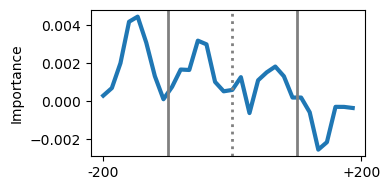

In [355]:
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
fig, ax = plt.subplots(1,1, figsize = (4,2))


sns.lineplot(gaussian_filter1d(frame_.groupby('level_0')['mean'].mean(), sigma=0.5), 
            # x='level_0',
            # y='mean',
             ax=ax,
            linewidth=3,
             
            )

# c1 = frame_['level_0'].quantile(q=0.25)
# c2 = frame_['level_0'].quantile(q=0.5)
# c3 = frame_['level_0'].quantile(q=0.75)

# c1 = 10
# c2 = 20
# c3 = 30

c1 = 7.5
c2 = 15
c3 = 22.5


ax.axvline(x=c1, linewidth=2,
           color='grey')
ax.axvline(x=c3, linewidth=2, color='grey')

ax.axvline(x=c2, linewidth=2, color='grey', ls=':')

ax.set(xlabel='', ylabel='Importance')

ax.xaxis.set_major_locator(plt.MaxNLocator(1))

ax.set(xticklabels=[0,'-200','+200'])

fig.tight_layout(),

# fig.savefig('MBNL1_profile.pdf')

In [340]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (3,2))


frame_upstream = frame[frame['level_0'] > 0]
frame_downstream = frame[frame['level_0'] > 0]

frame_upstream = frame
frame_downstream = frame


sns.lineplot(gaussian_filter1d(frame_upstream.groupby('level_0')['mean'].mean(), sigma=1.01)[:20], 
            # x='level_0',
            # y='mean',
             ax=ax1,
             linewidth=3
            )

sns.lineplot(gaussian_filter1d(frame_upstream.groupby('level_0')['mean'].mean(), sigma=1.01)[20:], 
            # x='level_0',
            # y='mean',
             ax=ax2, 
             linewidth=3
            )

# ymin = -0.05
# ymax = 0.05


# ax1.set_ylim([ymin,ymax])
# ax2.set_ylim([ymin,ymax])

ax2.get_yaxis().set_visible(False)

ax1.get_xaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)


ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)



fig.subplots_adjust(wspace=0, hspace=0)



ax1.axvline(x=c1, linewidth=3, color='grey', ls=':')
ax2.axvline(x=c1, linewidth=3, color='grey', ls=':')


# Model Weight Plotting

In [ ]:
# from ExplaiNN: For visualization, for each unit, we only included the products from correctly predicted sequences activating that unit’s filter by ≥ 50% of its maximum activation value. 

In [ ]:
from scipy.interpolate import UnivariateSpline
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram, set_link_color_palette

import fastcluster
import plotly.express as px

In [ ]:
pwd

In [ ]:
# RBP_dict = {}


# # # model_hek293_list_names = model_RBPslow.h5, model_RBPsmed.h5, model_RBPshigh.h5
# RBP_dict['hek293_low'] = np.array(['MBNL1', 'P53_NONO', 'PUM2', 'QKI', 'AGO3', 'FUS', 'TAF15', 'ZFP36', 'DICER1', 'EIF3A', 'EIF3D', 'EIF3G', 'SSB', 'PAPD5', 'CPSF4', 'CPSF3', 'RTCB', 'FXR1', 'NOP58', 'NOP56', 'FBL', 'LIN28A', 'LIN28B', 'UPF1', 'G35', 'G45', 'XPO5'])
# RBP_dict['hek293_med'] = np.array(['TARDBP', 'ELAVL2', 'ELAVL3', 'ELAVL4', 'RBM20', 'IGF2BP1', 'IGF2BP2', 'IGF2BP3', 'EWSR1', 'HNRNPD', 'RBPMS', 'SRRM4', 'AGO2', 'NUDT21', 'FIP1L1', 'CAPRIN1', 'FMR1iso7', 'FXR2', 'AGO1', 'L1RE1', 'ORF1'])
# RBP_dict['hek293_high'] = np.array(['DND1', 'CPSF7', 'CPSF6', 'CPSF1', 'CSTF2', 'CSTF2T', 'ZC3H7B', 'FMR1iso1', 'RBM10', 'MOV10', 'ELAVL1'])

In [ ]:
RBP_dict = {}

RBP_dict['HepG2_low']= np.array(['RBM22', 'GRSF1', 'CDC40', 'NOLC1', 'FKBP4', 'DGCR8', 'ZC3H11A', 'XRN2', 'SLTM', 'DDX55', 'TIA1', 'SRSF1', 'U2AF1', 'RBM15'])
RBP_dict['HepG2_mid1'] = np.array(['LSM11', 'NKRF', 'SUB1', 'NCBP2', 'UCHL5', 'LIN28B', 'IGF2BP3', 'SF3A3', 'AGGF1', 'DROSHA', 'DDX59', 'CSTF2', 'DKC1', 'EIF3H', 'FUBP3', 'SFPQ', 'HNRNPC', 'ILF3', 'TIAL1', 'HLTF', 'ZNF800', 'PABPN1', 'YBX3', 'FXR2'])
RBP_dict['HepG2_mid2'] = np.array(['GTF2F1', 'IGF2BP1', 'HNRNPK', 'XPO5', 'RPS3', 'SF3B4', 'LARP4', 'BUD13', 'SND1', 'G3BP1', 'AKAP1', 'KHSRP'])
RBP_dict['HepG2_high1'] = np.array(['DDX3X', 'PCBP2', 'FAM120A', 'HNRNPL', 'RBFOX2', 'PTBP1', 'MATR3', 'EFTUD2', 'PRPF4', 'UPF1'])
RBP_dict['HepG2_high2'] = np.array(['GRWD1', 'PRPF8', 'PPIG', 'CSTF2T', 'QKI', 'U2AF2', 'SUGP2', 'HNRNPM', 'AQR', 'BCLAF1'])

In [ ]:
# RBP_dict = {}

RBP_dict['K562_low'] = np.array(['MTPAP', 'RBM22', 'DHX30', 'DDX6', 'DDX55', 'TRA2A', 'XRN2', 'U2AF1', 'LSM11', 'ZC3H11A', 'NOLC1', 'KHDRBS1', 'GPKOW', 'DGCR8', 'AKAP1', 'FXR1', 'DDX52', 'AATF'])
RBP_dict['K562_mid1'] = np.array(['U2AF2', 'AKAP8L', 'METAP2', 'SMNDC1', 'GEMIN5', 'HNRNPK', 'SLTM', 'SRSF1', 'FMR1', 'SAFB2', 'DROSHA', 'RPS3', 'IGF2BP2', 'ILF3', 'RBFOX2', 'QKI', 'PCBP1', 'ZNF800', 'PUM1'])
RBP_dict['K562_mid2'] = np.array(['EFTUD2', 'LIN28B', 'AGGF1', 'HNRNPL', 'SND1', 'GTF2F1', 'EIF4G2', 'TIA1', 'TARDBP', 'FXR2', 'HNRNPM', 'IGF2BP1', 'PUM2', 'FAM120A', 'DDX3X', 'MATR3', 'FUS', 'GRWD1', 'PABPC4'])
RBP_dict['K562_high1'] = np.array(['BUD13', 'PTBP1', 'DDX24', 'EWSR1', 'RBM15'])
RBP_dict['K562_high2'] = np.array(['SF3B4', 'YBX3', 'UCHL5', 'KHSRP', 'ZNF622', 'NONO', 'EXOSC5', 'PRPF8', 'CSTF2T', 'AQR', 'UPF1'])

In [ ]:
first_RBP_int = 0

weight_dict = {}


for i, input_ in enumerate(model.layers[-2].input): # for each sub model's outputs ..

    
    n_RBPs = int(str(input_).split(',')[1].lstrip()[:-1]) # get number of RBPs in each multitask

    last_RBP_int = first_RBP_int + n_RBPs

    sub_name = str(input_).split(',')[5].split("'")[1]

    spatial_int = int(sub_name[-1])
    model_name = sub_name[:-2]

    # for each model input, get the weights 

    model_weights = model.weights[-2][:,0][first_RBP_int:last_RBP_int].numpy()


    # mutliply model weights by activation 
    # act = activations[first_RBP_int:last_RBP_int]

    # model_weights = model_weights*act

    first_RBP_int = last_RBP_int

    weight_dict[(model_name, spatial_int)] = model_weights

In [42]:
input_

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'HepG2_high2_3')>

In [43]:
first_RBP_int = 0

weight_dict = {}


for i, input_ in enumerate(model.layers[-2].input): # for each sub model's outputs ..
    
    n_RBPs = int(str(input_).split(',')[1].lstrip()[:-1]) # get number of RBPs in each multitask

    last_RBP_int = first_RBP_int + n_RBPs

    sub_name = str(input_).split(',')[5].split("'")[1]

    spatial_int = int(sub_name[-1])
    model_name = sub_name[:-2]

    # for each model input, get the weights 

    model_weights = model.weights[-2][:,0][first_RBP_int:last_RBP_int].numpy()


    # mutliply model weights by activation 
    # act = activations[first_RBP_int:last_RBP_int]
    # model_weights = model_weights*act

    first_RBP_int = last_RBP_int

    weight_dict[(model_name, spatial_int)] = model_weights

In [44]:
RBP_dict

{'HepG2_low': array(['RBM22', 'GRSF1', 'CDC40', 'NOLC1', 'FKBP4', 'DGCR8', 'ZC3H11A',
        'XRN2', 'SLTM', 'DDX55', 'TIA1', 'SRSF1', 'U2AF1', 'RBM15'],
       dtype='<U7'),
 'HepG2_mid1': array(['LSM11', 'NKRF', 'SUB1', 'NCBP2', 'UCHL5', 'LIN28B', 'IGF2BP3',
        'SF3A3', 'AGGF1', 'DROSHA', 'DDX59', 'CSTF2', 'DKC1', 'EIF3H',
        'FUBP3', 'SFPQ', 'HNRNPC', 'ILF3', 'TIAL1', 'HLTF', 'ZNF800',
        'PABPN1', 'YBX3', 'FXR2'], dtype='<U7'),
 'HepG2_mid2': array(['GTF2F1', 'IGF2BP1', 'HNRNPK', 'XPO5', 'RPS3', 'SF3B4', 'LARP4',
        'BUD13', 'SND1', 'G3BP1', 'AKAP1', 'KHSRP'], dtype='<U7'),
 'HepG2_high1': array(['DDX3X', 'PCBP2', 'FAM120A', 'HNRNPL', 'RBFOX2', 'PTBP1', 'MATR3',
        'EFTUD2', 'PRPF4', 'UPF1'], dtype='<U7'),
 'HepG2_high2': array(['GRWD1', 'PRPF8', 'PPIG', 'CSTF2T', 'QKI', 'U2AF2', 'SUGP2',
        'HNRNPM', 'AQR', 'BCLAF1'], dtype='<U6'),
 'K562_low': array(['MTPAP', 'RBM22', 'DHX30', 'DDX6', 'DDX55', 'TRA2A', 'XRN2',
        'U2AF1', 'LSM11', 'ZC3H11A', 'N

In [45]:
df_dict = {}

for i in range(4):
    
    df_dict[i] = pd.DataFrame()


for key, value in weight_dict.items():
    
    spatial_id = key[1]

    weight_df = pd.DataFrame(value)
    weight_df.set_index(RBP_dict[key[0]], inplace = True)
    
    df_dict[spatial_id] = pd.concat([df_dict[spatial_id], weight_df])

In [46]:
weights_reshaped = pd.concat([df_dict[0], df_dict[1], df_dict[2], df_dict[3]], axis=1)

In [47]:
weights_reshaped_ = (weights_reshaped.reset_index()
        .drop_duplicates(subset='index', keep='last')
        .set_index('index').sort_index())

In [48]:
weights_reshaped_.head()

,0,0,0,0
index,,,,
AATF,-0.007945,0.001410,0.007983,0.011587
AGGF1,-0.012182,0.003054,-0.000858,-0.011470
AKAP1,-0.009558,0.003620,0.002065,-0.005549
AKAP8L,-0.018162,0.010063,0.005974,0.002502
AQR,-0.020190,-0.005072,-0.020606,0.001432


In [49]:
weights_reshaped_ = weights_reshaped_.drop('ZC3H11A')

In [50]:
clustering_linkage = fastcluster.linkage(weights_reshaped_,
                    metric='euclidean',
                    method='ward',
                    preserve_input=True
                   )

new_row_idx = leaves_list(clustering_linkage)

<Axes: ylabel='index'>

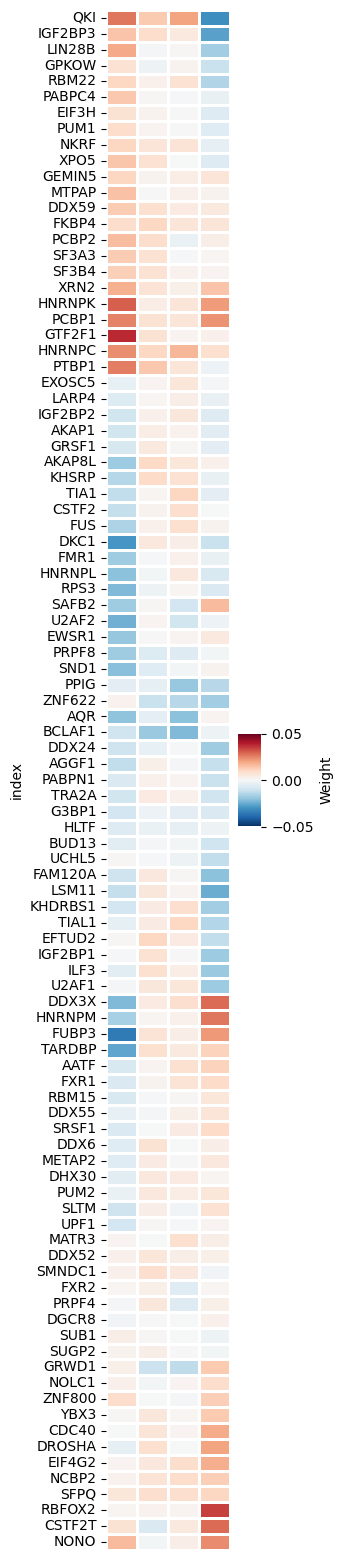

In [51]:
fig, ax1 = plt.subplots(1,1, figsize=(2,20))


sns.heatmap(weights_reshaped_.iloc[new_row_idx],
               #    standard_scale='rows',
               #    figsize=(3,6),
                cmap="RdBu_r",
                vmax=0.05,
                vmin=-0.05, 
                xticklabels=False,
                # yticklabels=RBP_names_array[new_row_idx],
                cbar=True,
                ax=ax1,
                linewidths=0.8, linecolor='white',
                cbar_kws={'shrink': 0.20, 'aspect':4, 'label':'Weight'}
           )

In [52]:
par_weights = pd.read_csv('./PARCLIP_weights.csv', index_col=0) 
par_weights.columns = [0,0,0,0]

In [53]:
weights_ = pd.concat([weights_reshaped_, par_weights],axis=0)

In [54]:
weights_ = weights_.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')

In [55]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
de = pd.read_csv('/c4/home/derek/data1/derek/data_scSLR/prenatal_brain/SCVI_differnetial_expression.csv', index_col=0)

In [ ]:
de = de[de.index.isin(weights_.index)]

In [ ]:
weights_ = weights_[weights_.index.isin(de.index)]

In [ ]:
de__=de[np.abs(de['lfc_mean']) > 0.25]

In [ ]:
weights__ = weights_.loc[de[np.abs(de['lfc_mean']) > 0.25].index]

In [ ]:
clustering_linkage = fastcluster.linkage(weights__,
                    metric='euclidean',
                    method='ward',
                    preserve_input=True
                   )

new_row_idx = leaves_list(clustering_linkage)

In [ ]:
from matplotlib import gridspec 
import matplotlib.colors as mcolors

In [ ]:
# # sample the colormaps that you want to use. Use 128 from each so we get 256
# # colors in total
# colors1 = plt.cm.viridis_r(np.linspace(0., 1, 128))
# colors2 = plt.cm.magma(np.linspace(0, 1, 128))

# # combine them and build a new colormap
# colors = np.vstack((colors1, colors2))
# mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

In [ ]:
def _plot():

    fig = plt.figure(figsize=(3,15))

    # Setup axes
    gs = gridspec.GridSpec(3,3,width_ratios=[1,0.15,0.1],wspace=0.2)
    axs = {}
    axs['1'] = fig.add_subplot(gs[:,0])
    axs['2'] = fig.add_subplot(gs[:,1])
        
    # Annual value
    plots = {}
    plots['heatmap_weights'] = sns.heatmap(weights__.iloc[new_row_idx],
               #    standard_scale='rows',
               #    figsize=(3,6),
                cmap="RdBu_r",
                vmax=0.05,
                vmin=-0.05, 
                xticklabels=False,
                cbar=False,
                ax=axs['1'],
                linewidths=0.8, linecolor='white',
           )

    axs['1'].tick_params(bottom=False, labelbottom=False, left=True, labelleft=True)
    axs['1'].set_ylabel('')


    plots['heatmap_exp'] = sns.heatmap(de__[['lfc_mean']].loc[weights__.iloc[new_row_idx].index],
               #    standard_scale='rows',
               #    figsize=(3,6),
                cmap='viridis',
                vmax=0.5,
                vmin=-0.5, 
                xticklabels=True,
                yticklabels=False,
                cbar=False,
                ax=axs['2'],
                linewidths=0.8, linecolor='white',
           )
    
    axs['2'].tick_params(bottom=False, labelbottom=True, left=False, labelleft=False)
    axs['2'].set_ylabel('')

    
    

    # Colour bars
    cbar_gs = gridspec.GridSpecFromSubplotSpec(10,1, subplot_spec=gs[:,2])
    cax_1 = fig.add_subplot(cbar_gs[4,0])
    cax_2 = fig.add_subplot(cbar_gs[6,0])
    plt.colorbar(plots['heatmap_weights'].collections[0], cax_1, label= 'Weight')
    plt.colorbar(plots['heatmap_exp'].collections[0], cax_2, label= 'Δ Expression')


    fig.savefig('./heatmap_RBP.pdf')
_plot()



In [ ]:
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(2,30), gridspec_kw={'width_ratios': (5,1)})

# fig.subplots_adjust(wspace=0, hspace=0)

# w = sns.heatmap(weights_.iloc[new_row_idx],
#                #    standard_scale='rows',
#                #    figsize=(3,6),
#                 cmap="RdBu_r",
#                 vmax=0.05,
#                 vmin=-0.05, 
#                 xticklabels=False,
#                 # yticklabels=RBP_names_array[new_row_idx],
#                 cbar=False,
#                 ax=ax1,
#                 linewidths=0.8, linecolor='white',
#                 cbar_kws={'shrink': 0.20, 'aspect':4, 'label':'Weight', 'anchor': (0.0, 0.5)}
#            )



# e = sns.heatmap(de[['lfc_mean']].loc[weights_.iloc[new_row_idx].index],
#                #    standard_scale='rows',
#                #    figsize=(3,6),
#                 cmap="viridis",
#                 vmax=1,
#                 vmin=-1, 
#                 xticklabels=True,
#                 yticklabels=False,
#                 cbar=False,
#                 ax=ax2,
#                 linewidths=0.8, linecolor='white',
#                 cbar_kws={'shrink': 0.20, 'aspect':4, 'label':'Weight', 'anchor': (0.5, 0.5)}
#            )

# ax1.set_ylabel('')
# ax2.set_ylabel('')


# cax1 = fig.add_subplot()
# fig.colorbar(w, cax=cax1, orientation='horizontal')

# cax2 = fig.add_subplot()
# fig.colorbar(e, cax=cax2, orientation='horizontal', extend='max')




In [ ]:
# getting activations for individual units. - create new truncated model,
# ending with lyer at which the sub-models are combined - 
# get outputs multiplied by weights...

In [ ]:
# for each layer in currents, generate a model and get outputs 

In [ ]:
value[-1]

In [ ]:
for key, value in currents.items():
    pass
    

In [ ]:
model = tf.keras.Model(input_seq, output, name='deepripe_explainn')

In [ ]:
base_models.items()

In [ ]:
input_dict = dict(zip(range(4),
         np.array_split(train_data[0].numpy()[0][:,0,:,:], input_sequence_split, axis=1)
        )
        )

In [ ]:
train_data[0].

In [ ]:
base_models.items()

In [ ]:
model__.name

In [ ]:
np.nanmedian

In [ ]:
arr_list = []

for i, model__ in  base_models.items():


    print(i)
    input_data = input_dict[i[1]]

    #get acitivies for all input sequences for sub model
    activities = model__.predict(input_data)


    max_per_RBP = activities.max(axis=0)

    mask = (activities >= (max_per_RBP*0.5))
    
    arr_list.append(np.nanmedian(np.where(mask, activities, np.nan), axis=0))


In [ ]:
activations = np.concatenate(arr_list)

In [ ]:
activations.shape

In [ ]:


max_per_RBP = activities.max(axis=0)

mask = (activities >= (max_per_RBP*0.5))

np.nanmean(np.where(mask, activities, np.nan), axis=0)

In [ ]:
np.nanmean(np.where(mask, activities, np.nan), axis=0).shape

In [ ]:
arr = np.empty()